In [1]:
import open3d as o3d
import torch
import numpy as np

import objaverse
import multiprocessing

from PIL import Image
import io
from matplotlib import pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# To see visualizations of all steps, set True
show_vis = False

In [3]:
tesla_uid = '2c91f1d43c174e1493e29b4a0e6229da'
model_annot = objaverse.load_annotations([tesla_uid])

In [4]:
processes = multiprocessing.cpu_count()
objects = objaverse.load_objects(
    uids=[tesla_uid],
    download_processes=processes
)

In [5]:
model_o3d = o3d.io.read_triangle_mesh(objects[tesla_uid])

In [6]:
if show_vis:
    o3d.visualization.draw_plotly([model_o3d])

In [7]:
# Rotate and Center
rotation_axis_angle = np.array([0, 0, 0])
rot_matrix = o3d.geometry.get_rotation_matrix_from_axis_angle(rotation_axis_angle)

model_o3d.rotate(rot_matrix)
model_bounding_box = model_o3d.get_axis_aligned_bounding_box()

bb_center = model_bounding_box.get_center()
translation_center = np.array([-bb_center[0], -bb_center[1], -model_bounding_box.min_bound[2]])

model_o3d.translate(translation_center)
model_bounding_box.translate(translation_center)

print(model_bounding_box.get_print_info())

[(-1.4521, -1.3093, 0.0000) - (1.4521, 1.3093, 4.5401)]


In [8]:
# Scale
scale_factor = 0.4 / model_bounding_box.max_bound[2]
model_o3d.scale(scale_factor, np.zeros(3))
model_bounding_box.scale(scale_factor, np.zeros(3))

print(model_bounding_box.get_print_info())

[(-0.1279, -0.1154, 0.0000) - (0.1279, 0.1154, 0.4000)]


In [9]:
if show_vis:
    o3d.visualization.draw_plotly([model_o3d])

In [10]:
from os import path

scene = 'scene0000_00'

dataset_path = '/mnt/3dcv/projects/openscene_test/data/scannet/scannet_3d'
scene_path = f'train/{scene}_vh_clean_2.pth'
path = path.join(dataset_path, scene_path)    

scene_array, scene_colors, scene_annot = torch.load(path)

scene_o3d = o3d.geometry.PointCloud()
scene_o3d.points = o3d.utility.Vector3dVector(scene_array)
scene_o3d.colors = o3d.utility.Vector3dVector(scene_colors)

scene_bounding_box = scene_o3d.get_oriented_bounding_box()

In [11]:
filter_annot = -1 # 1 = floor

if filter_annot >= 0:
    indices = (scene_annot == filter_annot)
else:
    indices = np.repeat(True, scene_annot.shape)

filtered_scene_array = scene_array[indices]
filtered_scene_colors = scene_colors[indices]
    
filtered_scene_o3d = o3d.geometry.PointCloud()
filtered_scene_o3d.points = o3d.utility.Vector3dVector(filtered_scene_array)
filtered_scene_o3d.colors = o3d.utility.Vector3dVector(filtered_scene_colors)

In [12]:
if show_vis:
    o3d.visualization.draw_plotly([filtered_scene_o3d])

In [13]:
# Find valid placement, "on top" of relevant points
center_placement = np.array([2.5, 6.])

bb_min = model_bounding_box.get_min_bound()
bb_max = model_bounding_box.get_max_bound()

lower_bound_mask = (center_placement + bb_min[:2] < filtered_scene_array[:, :2]).all(axis=1)
upper_bound_mask = (center_placement + bb_max[:2] > filtered_scene_array[:, :2]).all(axis=1)
bound_mask = lower_bound_mask & upper_bound_mask

assert bound_mask.sum() > 0

max_height = filtered_scene_array[bound_mask][:, 2].max()
model_position = np.concatenate([center_placement, np.array([max_height])])

model_o3d.translate(model_position)
model_bounding_box.translate(model_position)

AxisAlignedBoundingBox: min: (2.37207, 5.88465, 0.507067), max: (2.62793, 6.11535, 0.907067)

In [14]:
# Downsample to fit scene
down_model_o3d = model_o3d.sample_points_uniformly(1000)
down_model_o3d = down_model_o3d.voxel_down_sample(voxel_size=0.05)

if np.asarray(down_model_o3d.colors).size == 0:
    down_model_o3d.paint_uniform_color(np.array([0, 0, 0]))

augmented_scene_array = np.concatenate([np.asarray(scene_o3d.points), np.asarray(down_model_o3d.points)])
augmented_scene_colors = np.concatenate([np.asarray(scene_o3d.colors), np.asarray(down_model_o3d.colors)])

augmented_scene_o3d = o3d.geometry.PointCloud()
augmented_scene_o3d.points = o3d.utility.Vector3dVector(augmented_scene_array)
augmented_scene_o3d.colors = o3d.utility.Vector3dVector(augmented_scene_colors)

In [15]:
if show_vis:
    o3d.visualization.draw_plotly([augmented_scene_o3d])

In [16]:
# http://www.open3d.org/docs/latest/python_example/visualization/index.html#render-to-image-py

scene_img = '2900'

extrinsic_matrix = \
    np.loadtxt(f'/mnt/3dcv/projects/openscene_test/data/scannet/scannet_2d/{scene}/pose/{scene_img}.txt')
    
intrinsic_matrix = \
    np.loadtxt(f'/mnt/3dcv/projects/openscene_test/data/scannet/scannet_2d/intrinsics.txt')

img_path = f'/mnt/3dcv/projects/openscene_test/data/scannet/scannet_2d/{scene}/color/{scene_img}.jpg'
depth_path = f'/mnt/3dcv/projects/openscene_test/data/scannet/scannet_2d/{scene}/depth/{scene_img}.png'

scannet_img = np.asarray(o3d.io.read_image(img_path))
scannet_depth = np.asarray(o3d.io.read_image(depth_path))

img_height, img_width = scannet_depth.shape
render = o3d.visualization.rendering.OffscreenRenderer(img_width, img_height)

[Open3D INFO] EGL headless mode enabled.


In [17]:
render.scene.set_background([1, 1, 1, 0])
render.scene.show_axes(True)

white = o3d.visualization.rendering.MaterialRecord()
white.base_color = [1.0, 1.0, 1.0, 1.0]
white.shader = "defaultLit"

In [18]:
model_o3d.compute_triangle_normals()
model_o3d.compute_vertex_normals()
render.scene.add_geometry("model", model_o3d, white)

In [19]:
#render.setup_camera(intrinsic_matrix[:3, :3], extrinsic_matrix, img_width, img_height)
#render.setup_camera(intrinsic_matrix[:3, :3], cam_transform, img_width, img_height)

vfov = 2 * np.arctan(img_height / (2 * intrinsic_matrix[1, 1]))
eye = extrinsic_matrix[:3, 3]
lookat = eye + (extrinsic_matrix[:3, :3] @ np.array([0, 0, 1]))
up = (extrinsic_matrix[:3, :3] @ np.array([0, -1, 0]))

render.setup_camera(vfov*180/np.pi, lookat, eye, up)

In [20]:
img_model = np.asarray(render.render_to_image())
depth_model = np.asarray(render.render_to_depth_image(z_in_view_space=True)) * 1000

In [31]:
aug_depth = np.asarray(scannet_depth).copy()
aug_img = np.asarray(scannet_img).copy()

In [32]:
aug_depth_interp = aug_depth.copy()

# very simple (but not smart) interpolation of missing depth values for masking of 3d model
mask = (aug_depth==0)
aug_depth_interp[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), aug_depth[~mask])

#mask = np.all(np.array([aug_depth == 0, depth_model < np.inf]), axis=0)
#mask = np.any(np.array([aug_depth > depth_model, mask]), axis=0)

model_mask = aug_depth_interp > depth_model

aug_depth[model_mask] = depth_model[model_mask]
aug_img[model_mask] = img_model[model_mask]

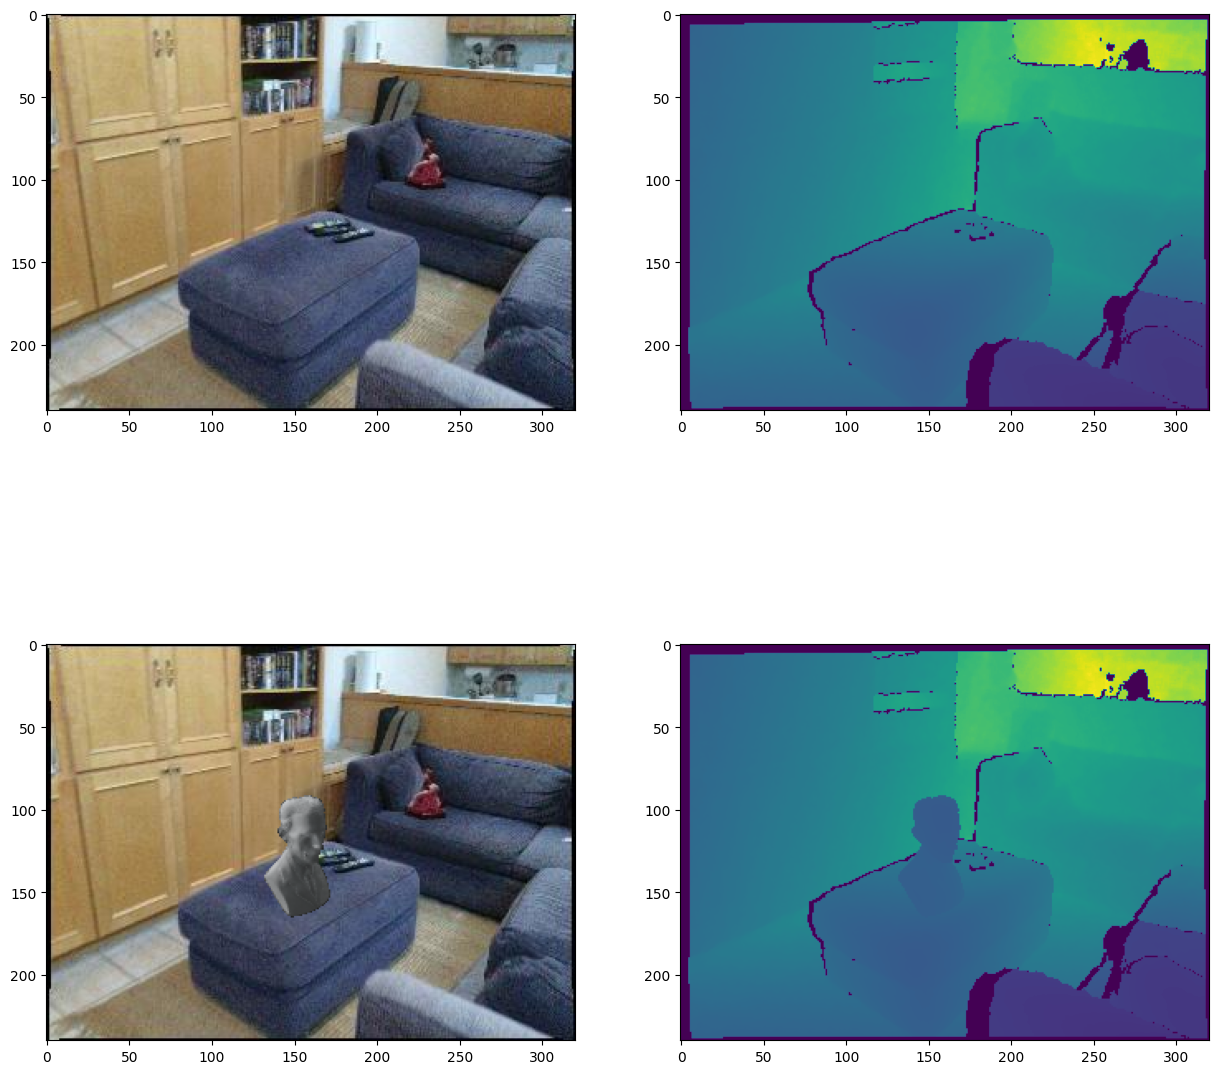

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0, 0].imshow(scannet_img)
ax[0, 1].imshow(scannet_depth)
ax[1, 0].imshow(aug_img)
ax[1, 1].imshow(aug_depth)